# 3D Contouring: Example

This is a simple notebook that shows the usage of the maximal empty spheres contouring as implemented in the  `LieConeSDFReconstruction` class in `lie_cone.py`.

In case the CGAL version was compiled as well (see instructions in its Readme.md), this notebook also includes an example how to use it.

A discrete set of signed distance function (SDF) values is sampled based on a ground truth mesh. 
The reconstructions for our empty spheres approach is shown along side ["Reach for the Arcs" (RFTA, Sellán et al. 2024)](https://dl.acm.org/doi/abs/10.1145/3641519.3657419).

Download and use the Armadillo mesh as ground truth. 
This is only an example, feel free to set `mesh_path` to a different `.obj` file.  

In [9]:
import os
# Download the Armadillo from github
mesh_path = "armadillo.obj"
if not os.path.exists(mesh_path) and mesh_path == "armadillo.obj":
    import wget
    url = 'https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/refs/heads/master/data/armadillo.obj'
    filename = wget.download(url)
    print()
    print(filename)
else:
    print("Found .obj file")

Found .obj file


Sample SDF values on a regular grid. Note that the bounding box is chosen slightly larger than the object.

In [10]:
import numpy as np

def sample_positions(n, random_sampling, sdf):
    if random_sampling:
        U = (np.random.rand(n*n*n, 3)-0.5)*2
    else:
        gx, gy, gz = np.meshgrid(np.linspace(-1.0, 1.0, n+1), np.linspace(-1.0, 1.0, n+1), np.linspace(-1.0, 1.0, n+1))
        U = np.vstack((gx.flatten(), gy.flatten(), gz.flatten())).T
    U_sdfvals = sdf(U)
    return U, U_sdfvals

import gpytoolbox as gpy

# Set up gt
V_gt, F_gt = gpy.read_mesh(mesh_path)
V_gt = gpy.normalize_points(V_gt)

s = 0.9 # 0.75
V_gt *= s/0.5

# Create and abstract SDF function that is the only connection to the shape
sdf = lambda x: gpy.signed_distance(x, V_gt, F_gt)[0]

In [12]:
# number of samples per dimensions
n = 20

# Sample SDF values on a regular grid
U, U_sdfvals = sample_positions(n,False,sdf)

# all methods use the Screened Poisson Surface Reconstruction (sPSR) implementation as made available in the gpytoolbox  
# setting the screening weight a bit lower can help avoid screening artifacts
psr_screening_weight = 1.

### RFTA

In [13]:
import time

# RFTA
strt = time.time()
R = gpy.reach_for_the_arcs(U, U_sdfvals,parallel=True,screening_weight=psr_screening_weight)
stp  = time.time()
print(f"RFTA (parallel): {stp-strt}s")

RFTA (parallel): 5.7843828201293945s


### Maximal Empty Spheres (Python)

In [14]:
from lie_cone import LieConeSDFReconstruction

strt = time.time()
cone = LieConeSDFReconstruction(np.concatenate([U,U_sdfvals[:,None]],axis=1),
                                    filter_type=3,cut_bbx_factor=1.,filter_results=False,
                                   psr_screening_weight=psr_screening_weight)

stp  = time.time()
print(f"Empty spheres rec: {stp-strt}s")

R_lc = cone.V, cone.F

Run cone construction(s)
☠️ Only consider edges connecting two full simplices ☠️
(106865, 6) (6, 6) (6, 6)


/home/kohlbrenner/projects/maximal_empty_spheres/maximal-empty-spheres/lie_geometry/lie_geometry.py:66: RuntimeWarning: invalid value encountered in sqrt
  l1 = (-b-np.sqrt(delta)) / (2*a)
/home/kohlbrenner/projects/maximal_empty_spheres/maximal-empty-spheres/lie_geometry/lie_geometry.py:66: RuntimeWarning: divide by zero encountered in divide
  l1 = (-b-np.sqrt(delta)) / (2*a)
/home/kohlbrenner/projects/maximal_empty_spheres/maximal-empty-spheres/lie_geometry/lie_geometry.py:66: RuntimeWarning: invalid value encountered in divide
  l1 = (-b-np.sqrt(delta)) / (2*a)
/home/kohlbrenner/projects/maximal_empty_spheres/maximal-empty-spheres/lie_geometry/lie_geometry.py:67: RuntimeWarning: invalid value encountered in sqrt
  l2 = (-b+np.sqrt(delta)) / (2*a)
/home/kohlbrenner/projects/maximal_empty_spheres/maximal-empty-spheres/lie_geometry/lie_geometry.py:67: RuntimeWarning: divide by zero encountered in divide
  l2 = (-b+np.sqrt(delta)) / (2*a)
/home/kohlbrenner/projects/maximal_empty_sphere

☠️ Only consider edges connecting two full simplices ☠️
Extract closest points
Run PSR
Empty spheres rec: 4.441075325012207s


### Maximal Empty Spheres (cpp, experimental)

This part of the codes requires the binary for the cpp version. See the `cgal/` folder for instructions on how to compile it.

Note that this uses code that is still under development.

In [15]:
LC_cgal_available=False
cgalbinpath = "./cgal/build/empty_spheres_reconstruction"
if os.path.exists(cgalbinpath):
    print("Found cgal executable")
    gridpath = "./cgal/tmp.csv"
    np.savetxt(gridpath, np.concatenate([U,U_sdfvals[:,None]],axis=1), delimiter=",")
    
    !{cgalbinpath} {gridpath}
    cgal_pwns = np.genfromtxt('./pwn.csv', delimiter=',')
    R_cgal = gpy.point_cloud_to_mesh(cgal_pwns[:,:3],cgal_pwns[:,3:],psr_screening_weight=psr_screening_weight)
    LC_cgal_available=True

Found cgal executable
Read 9261 spheres
Computed 7482 contact points with normals in 2.20281 sec.


## Visualize the results using polyscope

In [16]:
from matplotlib.colors import to_rgb
wong_colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
method_colors = {"CP" : to_rgb(wong_colors[1]), 
                "RFTA": to_rgb(wong_colors[2]),
                "MC"  : to_rgb(wong_colors[3])}

In [ ]:
import polyscope as ps

ps.init()
ps.set_ground_plane_mode("none")

ps.register_surface_mesh("GT", V_gt, F_gt,color=to_rgb("tab:gray"))
ps.register_surface_mesh("RFTA", *R,color=method_colors["RFTA"])
ps.register_surface_mesh("LC", *R_lc,color=method_colors["CP"])

if LC_cgal_available:
    ps.register_surface_mesh("LC_cgal", *R_cgal, color=method_colors["CP"])

ps.show()

# Timing:

In [17]:
# number of samples per dimensions
ns = [10,20,30,40,50,60,70,80,90,100]


timings         = {"RFTA":[], "MES":[]}
reconstructions = {"RFTA":[], "MES":[]}
Rs = []

In [19]:
for i,n in enumerate(ns):
    print(f"N = {n}")
    U, U_sdfvals = sample_positions(n,False,sdf)
    
    #strt = time.time()
    #R = gpy.reach_for_the_arcs(U, U_sdfvals,parallel=True,screening_weight=psr_screening_weight)
    #stp  = time.time()
    #print(f"    RFTA (parallel): {stp-strt}s")
    #timings["RFTA"].append(stp-strt)
    
    strt = time.time()
    np.savetxt(gridpath, np.concatenate([U,U_sdfvals[:,None]],axis=1), delimiter=",")
    !{cgalbinpath} {gridpath}
    cgal_pwns = np.genfromtxt('./pwn.csv', delimiter=',')
    R_cgal = gpy.point_cloud_to_mesh(cgal_pwns[:,:3],cgal_pwns[:,3:],psr_screening_weight=psr_screening_weight)
    stp  = time.time()
    print(f"    MES (CGAL): {stp-strt}s")
    reconstructions["MES"].append(R_cgal)
    timings["MES"].append(stp-strt)

    
    Rs.append([R,R_cgal])
    
    print(timings)

N = 10
Read 1331 spheres
Computed 1271 contact points with normals in 0.27185 sec.
    MES (CGAL): 0.848879337310791s
{'RFTA': [], 'MES': [0.848879337310791]}
N = 20
Read 9261 spheres
Computed 7482 contact points with normals in 2.21632 sec.
    MES (CGAL): 3.2795510292053223s
{'RFTA': [], 'MES': [0.848879337310791, 3.2795510292053223]}
N = 30
Read 29791 spheres
Computed 20336 contact points with normals in 8.15155 sec.
    MES (CGAL): 10.110512256622314s
{'RFTA': [], 'MES': [0.848879337310791, 3.2795510292053223, 10.110512256622314]}
N = 40
Read 68921 spheres
Computed 40216 contact points with normals in 24.6115 sec.
    MES (CGAL): 27.87571907043457s
{'RFTA': [], 'MES': [0.848879337310791, 3.2795510292053223, 10.110512256622314, 27.87571907043457]}
N = 50
Read 132651 spheres
Computed 68758 contact points with normals in 62.2367 sec.
    MES (CGAL): 67.24013662338257s
{'RFTA': [], 'MES': [0.848879337310791, 3.2795510292053223, 10.110512256622314, 27.87571907043457, 67.24013662338257]}

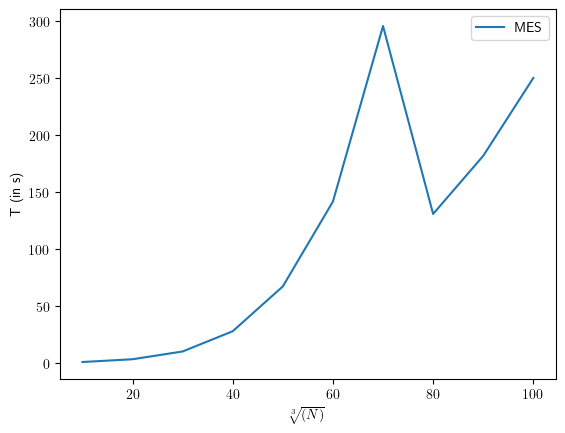

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
#plt.plot(ns, timings["RFTA"],label="RFTA")
plt.plot(ns,timings["MES"], label="MES")
plt.legend()
plt.xlabel(r"$\sqrt[3]{(N)}$")
plt.ylabel("T (in s)")
plt.show()

In [ ]:
import polyscope as ps
ps.init()
ps.set_ground_plane_mode("none")

ps.register_surface_mesh("GT", V_gt, F_gt,color=to_rgb("tab:gray"),enabled=False)

for i,n in enumerate(ns):
    ps.register_surface_mesh(f"RFTA_{n}",    *Rs[i][0],color=method_colors["RFTA"],enabled=False)
    ps.register_surface_mesh(f"LC_cgal_{n}", *Rs[i][1], color=method_colors["CP"], enabled=False)

ps.show()